In [16]:
"""
callejero.py

Matemática Discreta - IMAT
ICAI, Universidad Pontificia Comillas

Grupo: GP02A
Integrantes:
    - JAVIER ESCOBAR SERRANO
    - ENRIQUE FERNÁNDEZ-BAILLO RODRIÍGUEZ DE TEMBLEQUE

Descripción:
Librería con herramientas y clases auxiliares necesarias para la representación de un callejero en un grafo.

Complétese esta descripción según las funcionalidades agregadas por el grupo.
"""

#Constantes con las velocidades máximas establecidas por el enunciado para cada tipo de vía.
VELOCIDADES_CALLES={"AUTOVIA":100,"AVENIDA":90,"CARRETERA":70,"CALLEJON":30,"CAMINO":30,"ESTACION DE METRO":20,"PASADIZO":20,"PLAZUELA":20,"COLONIA":20}
VELOCIDAD_CALLES_ESTANDAR=50

import pandas as pd
import numpy as np
from dgt import process_data
from grafo import Grafo
from math import sqrt
df_cruces, df_direcc = process_data("data/cruces.csv", "data/direcciones.csv")
df_direcc["coordenadas"] = list(zip(df_direcc["Coordenada X (Guia Urbana) cm"], df_direcc["Coordenada Y (Guia Urbana) cm"]))

class Cruce:

    #Completar esta clase con los datos y métodos que se necesite asociar a cada cruce

    def __init__(self,coord_x,coord_y):
        self.coord_x=coord_x
        self.coord_y=coord_y
        self.calles = self.get_calles(df_cruces)
    
    """Se hace que la clase Cruce sea "hashable" mediante la implementación de los métodos
    __eq__ y __hash__, haciendo que dos objetos de tipo Cruce se consideren iguales cuando
    sus coordenadas coincidan (es decir, C1==C2 si y sólo si C1 y C2 tienen las mismas coordenadas),
    independientemente de los otros campos que puedan estar almacenados en los objetos.
    La función __hash__ se adapta en consecuencia para que sólo dependa del par (coord_x, coord_y).
    """
    def __eq__(self,other) -> int:
        if type(other) is type(self):
            return ((self.coord_x==other.coord_x) and (self.coord_y==other.coord_y))
        else:
            return False
    
    def __hash__(self) -> int:
        return hash((self.coord_x,self.coord_y))

    def get_calles(self, cruces: pd.DataFrame):
        return cruces[cruces["coordenadas"] == (self.coord_x, self.coord_y)]["Codigo de vía tratado"].unique()
    

class Calle:
    #Completar esta clase con los datos que sea necesario almacenar de cada calle para poder reconstruir los datos del callejero
    def __init__(self, ID):
        self.ID = ID
        self.direcciones = self.get_data(df_cruces, df_direcc)[1]
        self.cruces = self.get_data(df_cruces, df_direcc)[0]

    def get_data(self, cruces: pd.DataFrame, direcciones: pd.DataFrame)-> tuple:
        return (cruces[cruces["Codigo de vía tratado"] == self.ID].coordenadas.unique(), direcciones[direcciones["Codigo de via"] == self.ID])

    def get_velocidad(self):
        if self.direcciones.empty or self.direcciones["Clase de la via"].iloc[0] not in VELOCIDADES_CALLES:
            return VELOCIDAD_CALLES_ESTANDAR
        else:
            return VELOCIDADES_CALLES[self.direcciones["Clase de la via"].iloc[0]]
        
    def ordenar_cruces(self):
        cruces_ordenados = {}

        def funcion_aux(x, cruce):
            if x['Prefijo de numeración'] == "KM.":
                pass
            else:
                distancias[dist(x["coordenadas"], cruce)] = x["Número"]

        for cruce in self.cruces:
            try:
                distancias = {}
                self.direcciones.apply(lambda x: funcion_aux(x, cruce), axis=1)
                distancias = dict(sorted(distancias.items()))
                distancia_min = list(distancias.keys())[0]
                num_dist_min = distancias[distancia_min]
                
                if num_dist_min not in cruces_ordenados:
                    cruces_ordenados[num_dist_min] = cruce
                
                else:

                    num_anterior = num_dist_min - 2
                    num_siguiente = num_dist_min + 2
                    
                    while num_dist_min + 0.01 in cruces_ordenados:
                        num_dist_min += 0.01
                    
                    if len(distancias) < 3:
                        cruces_ordenados[num_dist_min + 0.01] = cruce
                        continue

                    error = True
                    while error:
                        try:
                            coords_anterior = self.direcciones.loc[self.direcciones["Número"] == num_anterior]['coordenadas'].values[0]
                            cruce_anterior = cruces_ordenados[num_dist_min]

                            dist_cruce_actual = dist(cruce, coords_anterior)
                            dist_cruce_anterior = dist(cruce_anterior, coords_anterior)
                            
                            if dist_cruce_actual < dist_cruce_anterior:
                                cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                                cruces_ordenados[num_dist_min] = cruce
                            else:
                                cruces_ordenados[num_dist_min + 0.01] = cruce
                            error = False

                        except:
                            try:
                                coords_siguiente = self.direcciones.loc[self.direcciones["Número"] == num_siguiente]['coordenadas'].values[0]
                                cruce_anterior = cruces_ordenados[num_dist_min]

                                dist_cruce_actual = dist(cruce, coords_siguiente)
                                dist_cruce_siguiente = dist(cruce_anterior, coords_siguiente)

                                if dist_cruce_actual < dist_cruce_siguiente:
                                    cruces_ordenados[num_dist_min + 0.01] = cruce
                                else:
                                    cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                                    cruces_ordenados[num_dist_min] = cruce
                                error = False
                            except:
                                num_anterior -= 2
                                num_siguiente += 2
                                if num_siguiente > 600:
                                    error = False
                                    cruces_ordenados[num_dist_min + 0.01] = cruce
                                    print("Error en la calle", self.ID, "con el cruce", cruce)
                                    print(cruces_ordenados)
                                    print()
            except:
                continue
        
        cruces_ordenados = dict(sorted(cruces_ordenados.items()))
        cruces_ordenados = list(cruces_ordenados.values())
        self.cruces = cruces_ordenados

def filtrar_por_radios(R: int):
    df_cruces["coordenadas"] = list(zip(df_cruces["Coordenada X (Guia Urbana) cm (cruce)"], df_cruces["Coordenada Y (Guia Urbana) cm (cruce)"]))
    coordenadas_a_tratar = sorted(df_cruces["coordenadas"].unique())
    coordenadas_limpias = []
    for coordenada in coordenadas_a_tratar:
        for x, y in coordenadas_limpias:
            if dist(coordenada, (x, y)) <= R:
                break
        else:
            coordenadas_limpias.append(coordenada)

    df_cruces["coordenadas"] = df_cruces["coordenadas"].apply(lambda x: x if x in coordenadas_limpias else closest(x, coordenadas_limpias, R))
    return coordenadas_limpias

def dist(coordenada1, coordenada2):
    return sqrt((coordenada1[0] - coordenada2[0])**2 + (coordenada1[1] - coordenada2[1])**2)

def closest(coordenada, coordenadas_limpias, R):
    coor_x, coor_y = coordenada[0], coordenada[1]
    for x, y in coordenadas_limpias:
        if (coor_x - R <= x <= coor_x + R) and (coor_y - R <= y <= coor_y + R):
            return (x, y)

if __name__ == "__main__":
    from time import time
    coordenadas_limpias = filtrar_por_radios(1500) # 8000 centímetros = 80 metros, se considera que un cruce está dentro del radio de otro si está a menos de 80 metros de distancia según las observaciones
    print(len(coordenadas_limpias))
    print(df_cruces["coordenadas"].head())

    # Creamos los cruces
    cruces = {}
    for coordenada in coordenadas_limpias:
        cruces[coordenada] = Cruce(coordenada[0], coordenada[1])
    list_cruces:list[Cruce] = list(cruces.values())

    # Creamos las calles
    calles = []
    for cruce in list_cruces: # Escogemos los cruces
        for calle in cruce.calles: # Escogemos las calles de cada cruce
            if calle not in calles: # Si la calle no está en la lista de calles, la añadimos
                calles.append(calle)  
    calles = [Calle(calle) for calle in calles] # Creamos los objetos calle

    # Creamos el grafo  
    grafo = Grafo(False)

    # Añadir vértices al grafo
    for cruce in list_cruces:
        grafo.agregar_vertice(cruce)
    
    # Para las aristas, se añaden las calles que conectan dos cruces como aristas del grafo
    for calle in calles:
        calle.ordenar_cruces()
        cruces_calle = calle.cruces
        for i in range(len(cruces_calle)):
            if i != len(cruces_calle) - 1:
                grafo.agregar_arista(cruces[cruces_calle[i]], cruces[cruces_calle[i+1]], None, calle.get_velocidad())

    # Pasemoslo a networkx
    import networkx as nx
    import matplotlib.pyplot as plt
    G = grafo.convertir_a_NetworkX()

    pos = {}
    for cruce in list_cruces:
        pos[cruce] = (cruce.coord_x, cruce.coord_y)

c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:40: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, encoding="iso-8859-1", delimiter=";")
c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:94: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  literal_splitted[columnas] = literal_splitted['Literal de numeracion'].apply(lambda x: pd.Series(listas(x)))


13421
0    (44260732, 448479748)
1    (44260732, 448479748)
2    (44290433, 448494484)
3    (44320997, 448510385)
4    (44322285, 448530840)
Name: coordenadas, dtype: object
Error en la calle 169900 con el cruce (42993240, 448070558)
{1: (42990855, 448065968), 1.01: (42993240, 448070558)}

Error en la calle 94700 con el cruce (43178645, 448021769)
{1: (43179841, 448020020), 1.01: (43178645, 448021769)}

Error en la calle 72985 con el cruce (43860141, 447741942)
{2: (43798883, 447687434), 2.01: (43798015, 447689954), 6: (43810454, 447738445), 15: (43845053, 447739500), 15.01: (43860141, 447741942)}

Error en la calle 72985 con el cruce (43858422, 447755327)
{2: (43798883, 447687434), 2.01: (43798015, 447689954), 6: (43810454, 447738445), 15: (43845053, 447739500), 15.01: (43860141, 447741942), 15.02: (43858422, 447755327)}

Error en la calle 263650 con el cruce (43957640, 447520490)
{1: (43960363, 447505923), 1.01: (43957640, 447520490)}

Error en la calle 263650 con el cruce (43951189,

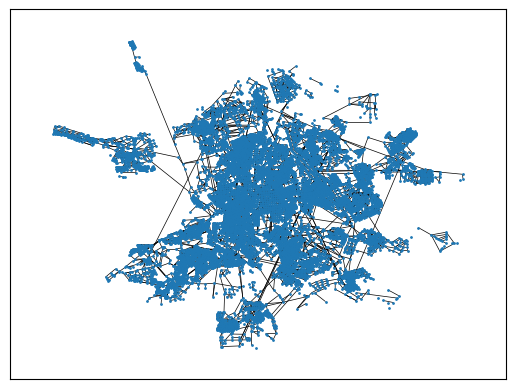

{<__main__.Cruce at 0x13212bc8490>: {<__main__.Cruce at 0x13230d55f50>: (None,
   50),
  <__main__.Cruce at 0x1322ff68750>: (None, 50)},
 <__main__.Cruce at 0x1322ff68750>: {<__main__.Cruce at 0x132126e5f50>: (None,
   50),
  <__main__.Cruce at 0x13212bc8490>: (None, 50),
  <__main__.Cruce at 0x132120ed890>: (None, 50)},
 <__main__.Cruce at 0x1321291d2d0>: {<__main__.Cruce at 0x13230d33190>: (None,
   50),
  <__main__.Cruce at 0x13230df4d10>: (None, 50),
  <__main__.Cruce at 0x132121d1e90>: (None, 50),
  <__main__.Cruce at 0x132127e77d0>: (None, 50)},
 <__main__.Cruce at 0x132126e5f50>: {<__main__.Cruce at 0x132125a3fd0>: (None,
   50),
  <__main__.Cruce at 0x1322ff68750>: (None, 50),
  <__main__.Cruce at 0x1322b2f4c90>: (None, 50)},
 <__main__.Cruce at 0x132125a3fd0>: {<__main__.Cruce at 0x13212bc9690>: (None,
   50),
  <__main__.Cruce at 0x132126e5f50>: (None, 50),
  <__main__.Cruce at 0x13230e9ce90>: (None, 50)},
 <__main__.Cruce at 0x13230df4d10>: {<__main__.Cruce at 0x1321291d2d0>

In [12]:
nx.draw_networkx_nodes(G, pos=pos, node_size=1)
nx.draw_networkx_edges(G, pos=pos, width=0.5, edge_color="black")
plt.show()
grafo.adyacencia

In [13]:
import numpy as np
df_direcc["coordenadas"] = list(zip(df_direcc["Coordenada X (Guia Urbana) cm"], df_direcc["Coordenada Y (Guia Urbana) cm"]))
calle_ejemplo = Calle(441300)
df_direcc.loc[df_direcc["Codigo de via"] == calle_ejemplo.ID]
cruces_ordenados = {}
print(calle_ejemplo.cruces)

def funcion_aux(df, cruce):
    distancias[dist(cruce, df["coordenadas"])] = df["Número"]

for cruce in calle_ejemplo.cruces:
    try:
        distancias = {}
        calle_ejemplo.direcciones.apply(lambda x: funcion_aux(x, cruce), axis=1)
        distancias = dict(sorted(distancias.items()))
        distancia_min = list(distancias.keys())[0]
        num_dist_min = distancias[distancia_min]
        while num_dist_min in cruces_ordenados:
            num_dist_min += 0.0001
        cruces_ordenados[num_dist_min] = cruce
    except:
        continue

cruces_ordenados = dict(sorted(cruces_ordenados.items()))
print(cruces_ordenados)
cruces_ordenados = list(cruces_ordenados.values())
calle_ejemplo.cruces = cruces_ordenados
len(calle_ejemplo.cruces)

[(44165531, 447660964) (44167990, 447662209) (44176678, 447666608)
 (44189814, 447673260) (44197755, 447677891) (44208658, 447685945)
 (44217383, 447692137) (44221107, 447693340) (44238518, 447704227)
 (44241296, 447704444) (44236753, 447710313) (44235830, 447707639)
 (44245168, 447711315) (44255040, 447717472) (44261003, 447720744)
 (44263020, 447721976) (44268923, 447725591) (44278772, 447733000)
 (44283903, 447738132) (44289242, 447743814) (44291239, 447745858)
 (44293712, 447748289) (44296571, 447750738) (44300914, 447754279)
 (44307426, 447759601) (44313673, 447764635) (44316813, 447767166)
 (44318054, 447768209) (44322923, 447772305) (44324495, 447773627)
 (44330451, 447778971) (44332171, 447780659) (44341757, 447790077)
 (44347356, 447794419) (44354200, 447799112) (44358883, 447802524)
 (44362049, 447805527) (44364589, 447808169) (44372467, 447817075)
 (44402908, 447879529) (44405075, 447881706) (44406351, 447885422)
 (44408223, 447890869) (44416155, 447914077) (44437561, 447924

63

In [14]:
import numpy as np
df_direcc["coordenadas"] = list(zip(df_direcc["Coordenada X (Guia Urbana) cm"], df_direcc["Coordenada Y (Guia Urbana) cm"]))
calle_ejemplo = Calle(441300)
df_direcc.loc[df_direcc["Codigo de via"] == calle_ejemplo.ID]
cruces_ordenados = {}
# print(calle_ejemplo.cruces)

def funcion_aux(df, cruce):
    distancias[dist(cruce, df["coordenadas"])] = df["Número"]

for cruce in calle_ejemplo.cruces:
    try:
        distancias = {}
        calle_ejemplo.direcciones.apply(lambda x: funcion_aux(x, cruce), axis=1)
        distancias = dict(sorted(distancias.items()))
        distancia_min = list(distancias.keys())[0]
        num_dist_min = distancias[distancia_min]
        
        if num_dist_min not in cruces_ordenados:
            cruces_ordenados[num_dist_min] = cruce
        
        else:
            num_anterior = num_dist_min - 2
            num_siguiente = num_dist_min + 2
            
            while num_dist_min + 0.01 in cruces_ordenados:
                num_dist_min += 0.01
            
            error = True
            while error:
                try:
                    coords_anterior = calle_ejemplo.direcciones.loc[calle_ejemplo.direcciones["Número"] == num_anterior]['coordenadas'].values[0]
                    cruce_anterior = cruces_ordenados[num_dist_min]

                    dist_cruce_actual = dist(cruce, coords_anterior)
                    dist_cruce_anterior = dist(cruce_anterior, coords_anterior)
                    
                    if dist_cruce_actual < dist_cruce_anterior:
                        cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                        cruces_ordenados[num_dist_min] = cruce
                    else:
                        cruces_ordenados[num_dist_min + 0.01] = cruce
                    error = False

                except:
                    try:
                        coords_siguiente = calle_ejemplo.direcciones.loc[calle_ejemplo.direcciones["Número"] == num_siguiente]['coordenadas'].values[0]
                        cruce_anterior = cruces_ordenados[num_dist_min]

                        dist_cruce_actual = dist(cruce, coords_siguiente)
                        dist_cruce_siguiente = dist(cruce_anterior, coords_siguiente)

                        if dist_cruce_actual < dist_cruce_siguiente:
                            cruces_ordenados[num_dist_min + 0.01] = cruce
                        else:
                            cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                            cruces_ordenados[num_dist_min] = cruce
                        error = False
                    except:
                        num_siguiente += 2
    except:
        continue

cruces_ordenados = dict(sorted(cruces_ordenados.items()))
print(cruces_ordenados)
cruces_ordenados = list(cruces_ordenados.values())
calle_ejemplo.cruces = cruces_ordenados
len(calle_ejemplo.cruces)

{2: (44165531, 447660964), 2.01: (44167990, 447662209), 3: (44176678, 447666608), 17: (44189814, 447673260), 20: (44197755, 447677891), 21: (44208658, 447685945), 27: (44235830, 447707639), 32: (44217383, 447692137), 33: (44236753, 447710313), 36: (44221107, 447693340), 42: (44238518, 447704227), 60: (44241296, 447704444), 62: (44245168, 447711315), 66: (44255040, 447717472), 68: (44261003, 447720744), 68.01: (44263020, 447721976), 76: (44268923, 447725591), 89: (44300914, 447754279), 90: (44278772, 447733000), 98: (44283903, 447738132), 101: (44307426, 447759601), 108: (44289242, 447743814), 110: (44291239, 447745858), 113: (44313673, 447764635), 116: (44293712, 447748289), 121: (44318054, 447768209), 124: (44296571, 447750738), 127: (44322923, 447772305), 135: (44332171, 447780659), 153: (44347356, 447794419), 156: (44316813, 447767166), 163: (44358883, 447802524), 165: (44362049, 447805527), 166: (44324495, 447773627), 170: (44330451, 447778971), 188: (44341757, 447790077), 202: (44

63